# CHURN Prediction - ORANGE

Alessandro Varnelli <br>
Submission: 12.04

## Libraries to import

In [2]:
library(data.table)  # Data manipulate
#library(mlr)         # ML toolkit
library(caret)       # ML toolkit
library(ggplot2)     # Visualization
library(pROC)        # AUC, ROC
library(e1071)       # Evaluation
library(gridExtra)   # Visualization
#library(kknn)        # kNN model
library(nnet)        # One-vs-All Logistic Regression
library(dummies)     # Data processing
library(corrplot)
library(plyr)
library(fastDummies)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'nnet' was built under R version 3.6.3"dummies-1.5.6 provided by Decision Patterns

Warning message:
"package 'corrplot' was built under R version 3.6.3"corrplot 0.84 loaded
Warning message:
"package 'fastDummies' was built under R version 3.6.3"

## Import of data

In [149]:
data_complete <-  read.csv("C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_churn_train.csv")

## Data Preprocessing for Train Data

In [152]:
#creation of dummy variables
dataf <- dummy_cols(data_complete, select_columns = c(colnames(data_complete[,192:231])))

In [153]:
#deletion of base columns used for dummies
dataf_clean <- dummy_cols(dataf, select_columns = c(colnames(data_complete[,192:231])),
           remove_selected_columns = TRUE)

In [154]:
#deleting columns that present more than 50% NA values
dat <- dataf_clean[, colMeans(is.na(dataf_clean)) <= .5]
dim(dat)

[1] 10000 27617

## Data Preprocessing for Test Data

In [156]:
test_base <- read.csv("C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_churn_test.csv")

In [157]:
#as before, I create the dummy variables
testf <- dummy_cols(test_base, select_columns = c(colnames(test_base[,192:231])))

In [158]:
#as before, we delete starting columns
testf_clean <- dummy_cols(testf, select_columns = c(colnames(test_base[,192:231])),
           remove_selected_columns = TRUE)

## Feature dimensionality reduction

In [155]:
# Removing Zero and Near Zero-Variance Predictors
nzv <- nearZeroVar(dat)
dat <- dat[, -nzv]
dim(dat)

[1] 10000   108

In [159]:
# Putting nan values to 0
dat[is.na(dat)] <- 0

In [160]:
# Identifying numeric features
numericData <- dat[sapply(dat, is.numeric)]

In [161]:
# Calculating correlation matrix
descrCorr <- cor(numericData)

In [162]:
# Printing correlation matrix
print(descrCorr)
summary(descrCorr[upper.tri(descrCorr)])

                                       cust_id          Var6          Var7
cust_id                           1.000000e+00 -0.0083241152 -0.0208285094
Var6                             -8.324115e-03  1.0000000000  0.1833471499
Var7                             -2.082851e-02  0.1833471499  1.0000000000
Var13                            -1.543395e-02  0.1009665120  0.3567188348
Var21                            -5.110610e-03  0.5889079889  0.1015967523
Var22                            -6.555241e-03  0.5850334296  0.1012043421
Var24                             1.602401e-03  0.4597102731  0.1201386762
Var25                             2.237218e-03  0.5490545835  0.1182762347
Var28                            -9.486207e-03  0.0885862438  0.1846940138
Var35                            -7.995240e-03  0.0197400510  0.0223243404
Var38                            -5.541020e-03  0.0640892449  0.1051324030
Var57                            -5.921492e-03  0.0026530850 -0.0235835282
Var65                    

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.000000 -0.026527  0.002788  0.012797  0.040143  1.000000 

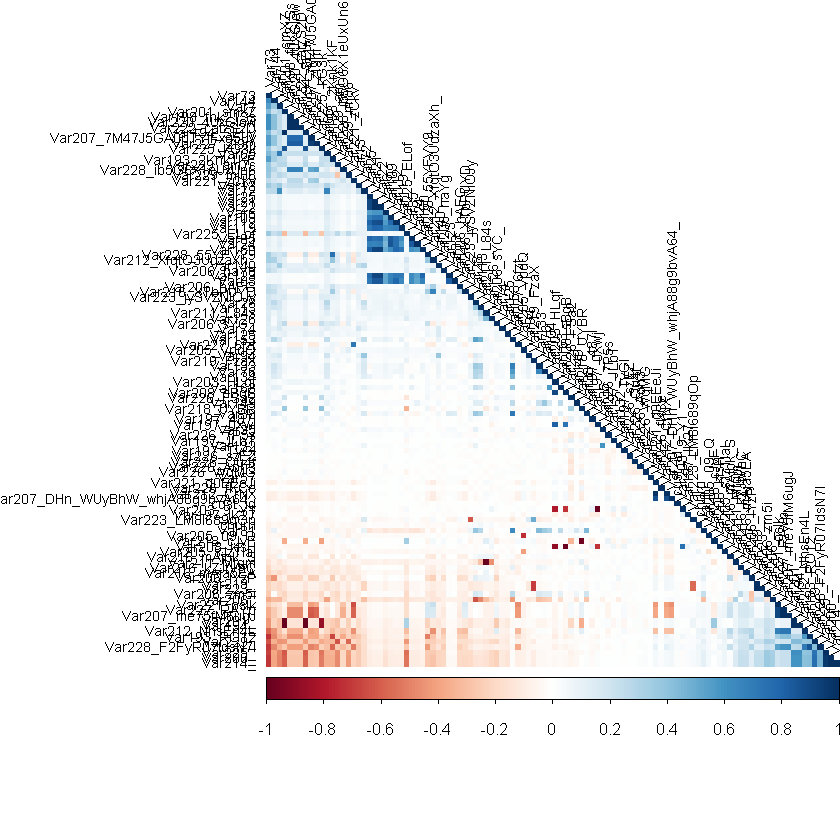

In [164]:
# Check Correlation Plot
corrplot(descrCorr, order = "FPC", method = "color", type = "lower", tl.cex = 0.7, tl.col = rgb(0, 0, 0))



In [165]:
# Looking for attributes that are highly corrected among each other
highlyCorrelated <- findCorrelation(descrCorr, cutoff=0.7)

In [166]:
# Indentifying names of significantly correlated features
highlyCorCol <- colnames(numericData)[highlyCorrelated]

In [167]:
# We now remove highly correlated variables. We save the result of this into a new dataset
dat_cl <- dat[, -which(colnames(dat) %in% highlyCorCol)]
dim(dat_cl)

[1] 10000    70

In [168]:
# I get the common columns to keep in consideration for ML applications
# I just want columns that are in common from the cleaned training dataset and the test dataset. 
# In this way I avoid retaking the previous process for feature selection for test too. I avoid the risk of having different columns.
columns_common <- intersect(colnames(testf_clean), colnames(dat_cl))

In [169]:
testf_clean <- testf_clean[,columns_common]

In [170]:
# I replace missing values with 0.
testf_clean[is.na(testf_clean)] <- 0

In [176]:
# I need to reorder dat_cl columns to make it easier to create the ML formula
order_l <- append(colnames(testf_clean), 'churn')
dat_cl <- dat_cl[, order_l ]

In [177]:
# check to verify everything is at right order
str(dat_cl)

'data.frame':	10000 obs. of  70 variables:
 $ cust_id             : int  3 4 7 8 9 14 15 18 19 21 ...
 $ Var6                : num  1351 644 2583 1463 77 ...
 $ Var7                : num  7 0 0 7 0 7 7 0 7 7 ...
 $ Var13               : num  120 0 0 5068 0 ...
 $ Var24               : num  10 0 42 12 0 8 12 0 0 0 ...
 $ Var28               : num  200 187 357 167 279 ...
 $ Var35               : num  0 0 5 0 5 0 0 0 0 0 ...
 $ Var38               : num  0 5577498 5449656 33576 950682 ...
 $ Var57               : num  2.8 3.29 1.88 5.64 4.85 ...
 $ Var65               : num  36 9 9 9 9 9 9 0 9 9 ...
 $ Var72               : num  3 3 0 3 0 3 0 0 3 0 ...
 $ Var74               : num  0 0 0 462 0 35 0 0 14 0 ...
 $ Var76               : num  414816 5472032 620688 34960 4838400 ...
 $ Var81               : num  36021 104523 19656 6719 406602 ...
 $ Var83               : num  15 10 120 5 5 25 20 0 0 0 ...
 $ Var94               : num  11976 2265 0 74901 0 ...
 $ Var113              : num  -17

In [178]:
str(test)

'data.frame':	10000 obs. of  69 variables:
 $ cust_id             : int  1 2 5 6 10 11 12 13 16 17 ...
 $ Var6                : int  224 7511 70 2863 770 553 826 1897 0 0 ...
 $ Var7                : int  0 7 0 7 7 0 7 7 0 0 ...
 $ Var13               : int  0 44 0 72 160 80 508 0 0 0 ...
 $ Var24               : int  2 22 0 6 4 6 0 2 0 0 ...
 $ Var28               : num  314 254 430 167 326 ...
 $ Var35               : int  0 0 0 5 0 0 0 0 0 0 ...
 $ Var38               : int  4276908 2420238 2008722 257148 2170002 0 105318 8091000 0 0 ...
 $ Var57               : num  1.376 6.49 6.791 0.921 3.401 ...
 $ Var65               : int  9 9 9 9 9 9 9 9 0 0 ...
 $ Var72               : int  3 0 3 0 3 0 3 3 0 0 ...
 $ Var74               : int  0 0 0 0 7 0 42 0 0 0 ...
 $ Var76               : int  1414664 2301736 3592072 2685128 633616 359184 4808064 1656472 0 0 ...
 $ Var81               : num  214920 18881 202726 22482 229352 ...
 $ Var83               : int  35 5 15 0 5 10 5 10 0 0 ...
 $

## Business Problem identification:


In [171]:
# How many customers churned over the total in the train dataset?
sum(dat_cl$churn) /10000

[1] 0.0736

7.36%. This information might be relevant in the future to have a better idea about the accuracy of our prediction in real life.

In [179]:
# I create a formula avoiding to insert the churn field and the cust_id 
formula <- as.formula(paste('churn ~ ',paste(colnames(train_cl[,2:68]), collapse=' + ')))
formula

churn ~ Var6 + Var7 + Var13 + Var24 + Var28 + Var35 + Var38 + 
    Var57 + Var65 + Var72 + Var74 + Var76 + Var81 + Var83 + Var94 + 
    Var113 + Var125 + Var126 + Var132 + Var134 + Var140 + Var144 + 
    Var149 + Var163 + Var193_RO12 + Var197_0Xwj + Var197_487l + 
    Var197_JLbT + Var197_lK27 + Var197_TyGl + Var205_09_Q + Var205_sJzTlal + 
    Var206_ + Var206_hAFG + Var206_haYg + Var206_IYzP + Var206_sYC_ + 
    Var206_zm5i + Var211_Mtgm + Var212_XfqtO3UdzaXh_ + Var216_kZJtVhC + 
    Var216_mAja5EA + Var216_mAjbk_S + Var216_XTbPUYD + Var218_UYBR + 
    Var219_FzaX + Var221_d0EEeJi + Var221_oslk + Var223_ + Var223_jySVZNlOJy + 
    Var223_LM8l689qOp + Var225_ELof + Var225_kG3k + Var226_7P5s + 
    Var226_Aoh3 + Var226_fKCe + Var226_FSa2 + Var226_Qu4f + Var226_szEZ + 
    Var226_WqMG + Var227_6fzt + Var227_ZI9m + Var228_55YFVY9 + 
    Var228_ib5G6X1eUxUn6 + Var229_ + Var229_am7c + Var229_mj86

In [180]:
# I create an image of the real test dataset but without the cust_id column.
test_cl <- test[,2:69]

## Models I would like to use:
- logistic regression
- xgboost
- svm
- neural network
- random forest

In [192]:
set.seed(3456)
trainIndex <- createDataPartition(dat_cl$churn, p = .7,
                                  list = FALSE,
                                  times = 1)
train <- dat_cl[ trainIndex,]
valid <- dat_cl[-trainIndex,]

In [193]:
sum(train$churn)/7000

[1] 0.07014286

In [1]:
sum(valid$churn)/3000

ERROR: Error in eval(expr, envir, enclos): object 'valid' not found


As the random split looks fine and churn ratios look similar, we can start with the models.

In [205]:
# I define a function that I will recall to collect predictions in the format required by Kaggle.
threshold <- 0.15
output_results <- function(pred_test_prob, threshold) {
  TEST_NUM_cus <- read.csv("C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_churn_test.csv")
  cust_ids <- c(TEST_NUM_cus[,1])  
  list_pred <- c(pred_test_prob)
  list_pred <- ifelse(list_pred > threshold, 1, 0)  
  column.names <- c("cust_id","churn")

  # Take these vectors as input to the array.
  result <- array(c(cust_ids,list_pred),dim = c(10000,2))  
  colnames(result) <- c("cust_id","churn")  
    
    
  return(result)
}

## Logistic regression


In [195]:
md_logreg <- glm(formula,
                 data=train, family=binomial)
summary(md_logreg)


Call:
glm(formula = formula, family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8428  -0.4222  -0.3425  -0.2597   3.0212  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.253e+00  1.179e+00  -1.911 0.055948 .  
Var6                  3.595e-06  2.239e-05   0.161 0.872459    
Var7                  3.856e-03  1.380e-02   0.279 0.780025    
Var13                -5.744e-05  3.991e-05  -1.439 0.150092    
Var24                -5.988e-03  8.051e-03  -0.744 0.457043    
Var28                 2.653e-04  6.116e-04   0.434 0.664499    
Var35                -1.813e-02  2.176e-02  -0.833 0.404867    
Var38                -3.341e-08  2.038e-08  -1.640 0.101106    
Var57                -1.113e-02  2.376e-02  -0.469 0.639415    
Var65                -1.858e-02  8.845e-03  -2.100 0.035715 *  
Var72                 2.514e-02  3.007e-02   0.836 0.403110    
Var74                -4.178e-04  3.675e-

In [197]:
# Prediction on train
pred_train_prob <- predict(md_logreg, newdata=train[,2:69], type='response')
head(pred_train_prob)

2          3          4          5          6          7 
0.05258209 0.17631984 0.04753338 0.04816644 0.07870039 0.04541505

In [201]:
# Predictions on validation set
pred_valid_prob <- predict(md_logreg, newdata=valid[,2:69], type='response')
head(pred_valid_prob)

1          8         11         14         15         18 
0.01959620 0.02796150 0.03262499 0.09470562 0.06917620 0.15070264

In [203]:
# Predictions on test set
pred_test_prob <- predict(md_logreg, newdata=test[,2:69], type='response')
head(pred_test_prob)

1          2          3          4          5          6 
0.07768804 0.06808206 0.08348925 0.10568533 0.09736862 0.06477500

In [199]:
#Evaluations:
threshold <- 0.5  # Decision threshold
pred_train <- rep(0, length(pred_train_prob))
pred_train[pred_train_prob > threshold] <- 1

# Confusion matrix
print('Confusion matrix:')
table(pred_train, train$churn)

# Accuracy and error rate
acc <- mean(pred_train == train$churn)
err_rate <- 1 - acc
print(paste('Accuracy =', round(acc, 2), '%'))
print(paste('Error =', round(err_rate, 2), '%'))

# AUC
pred_roc <- pROC::roc(as.numeric(pred_train_prob), as.numeric(train$churn == 1))
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


          
pred_train    0    1
         0 6507  490
         1    2    1

[1] "Accuracy = 0.93 %"
[1] "Error = 0.07 %"


Warning message in roc.default(as.numeric(pred_train_prob), as.numeric(train$churn == :
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"Setting levels: control = 4.37978606460873e-07, case = 1.99840843305799e-06
Setting direction: controls < cases


[1] "AUC = 0.5"


In [207]:
outcome <- output_results(pred_test_prob, 0.15)

In [210]:
sum(outcome[,2])

[1] 512

In [32]:
write.csv(outcome,"C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_30.03_sub.csv", row.names = FALSE)

## SVM

In [277]:
md_svc <- svm(formula, data=train[,2:69], kernel='radial', cost=0.1, scale=F)

In [3]:
ypred <- predict(md_svc, valid[,2:69])

ERROR: Error in predict(md_svc, valid): object 'md_svc' not found


In [ ]:
roc_obj <- roc(valid$churn, ypred)
auc(roc_obj)
## Area under the curve: 0.825
roc_df <- data.frame(
  TPR=rev(roc_obj$sensitivities), 
  FPR=rev(1 - roc_obj$specificities), 
  labels=roc_obj$response, 
  scores=roc_obj$predictor)

In [279]:
pred <- predict(md_svc, train, decision.values = TRUE, probability = TRUE)

In [280]:
head(pred)

2          3          4          5          6          7 
0.09971447 0.20752697 0.09971447 0.09971447 0.09971447 0.10049572

In [291]:
ypred <- predict(md_svc, test)

In [292]:
head(ypred)

1        2        3        4        5        6 
0.107527 0.107527 0.107527 0.107527 0.107527 0.107527

In [295]:
outcome <- output_results(ypred, 0.1)

In [296]:
sum(outcome[,2])

[1] 0

In [276]:
write.csv(result,"C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_30.03_sub.csv", row.names = FALSE)

## Random Forest

In [118]:
library('randomForest')

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:ggplot2':

    margin



In [215]:
# Fit bagging model, use all predictors
md_bagtree <- randomForest(formula, data=train[,2:69], mtry=13, importance=T)
md_bagtree

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Call:
 randomForest(formula = formula, data = train, mtry = 13, importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 0.06445582
                    % Var explained: 1.18

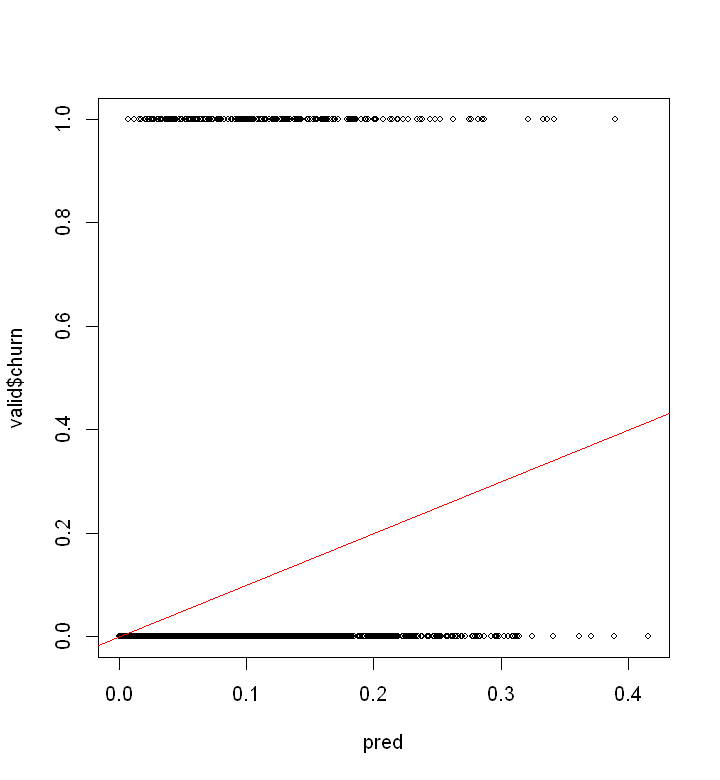

In [216]:
pred <- predict(md_bagtree, newdata=valid[,2:69])

In [217]:
list_pred <- c(pred)
list_pred <- ifelse(list_pred > 0.15, 1, 0)  

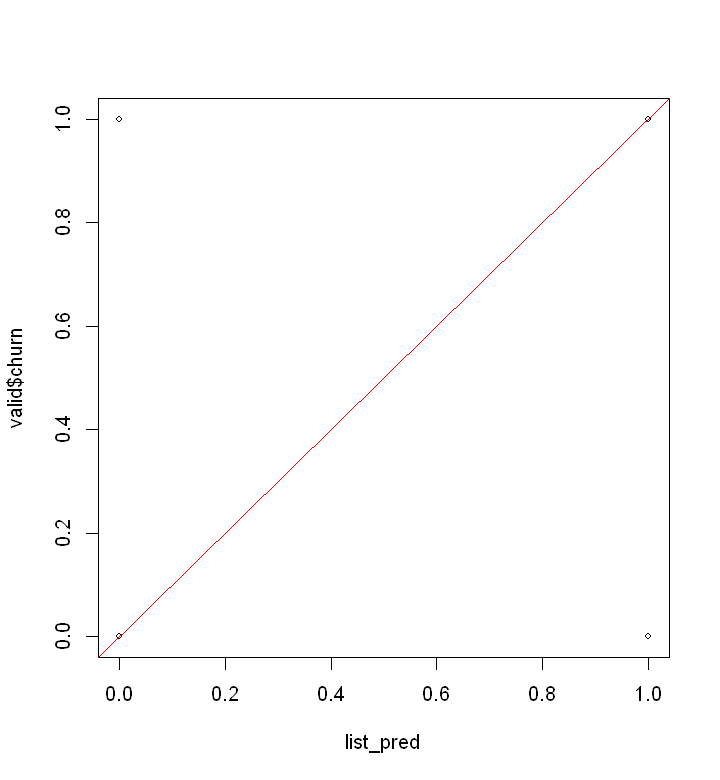

In [218]:
options(repr.plot.width=6, repr.plot.height=6.5)
plot(list_pred, valid$churn, cex=0.7)
abline(0, 1, col='red')

In [ ]:
roc_obj <- roc(valid$churn, list_pred)
auc(roc_obj)
## Area under the curve: 0.825
roc_df <- data.frame(
  TPR=rev(roc_obj$sensitivities), 
  FPR=rev(1 - roc_obj$specificities), 
  labels=roc_obj$response, 
  scores=roc_obj$predictor)

In [219]:
# Make prediction
pred <- predict(md_bagtree, newdata=test)

In [220]:
head(pred)

1          2          3          4          5          6 
0.08336667 0.10396667 0.11076667 0.10423333 0.11953333 0.02206667

In [221]:
outcome <- output_results(pred, 0.15)

In [140]:
sum(outcome[,2])

[1] 582

In [222]:
write.csv(outcome,"C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_30.03_sub.csv", row.names = FALSE)

In [ ]:
#dimensionality reduction random forest

In [224]:
#Evaluate variable importance
imp = importance(md_bagtree, type=1)
imp <- data.frame(predictors=rownames(imp),imp)

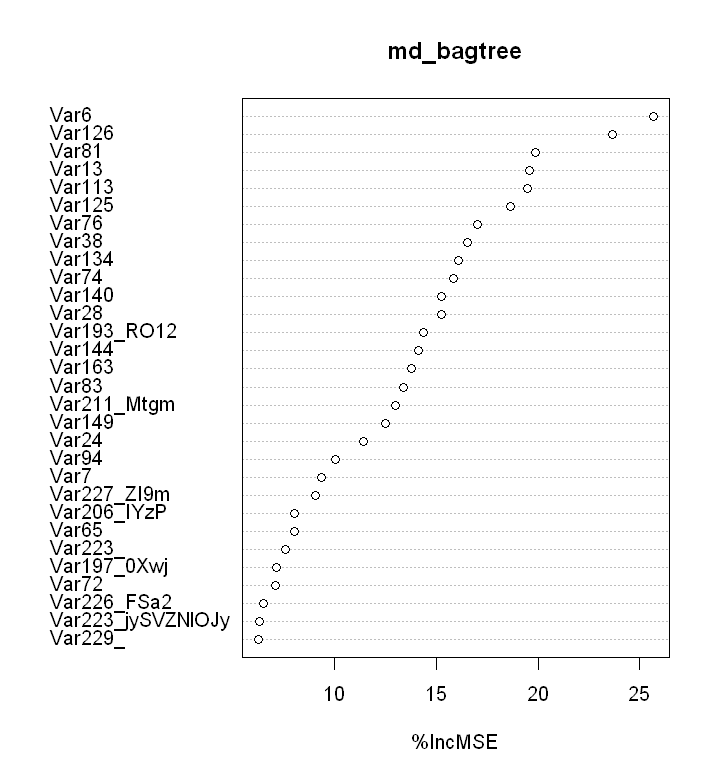

In [225]:
# Plot Important Variables
varImpPlot(md_bagtree, type=1)

## Neural Network

In [226]:
library(neuralnet)

In [228]:
nn=neuralnet(formula,data=train[,2:69], hidden=3,act.fct = "logistic",linear.output = FALSE)

In [229]:
plot(nn)

In [ ]:
nn_pred <- predict(nn, valid[,2:69])

In [ ]:
list_pred <- c(nnpred)
list_pred <- ifelse(list_pred > 0.15, 1, 0)  

In [ ]:
roc_obj <- roc(valid$churn, list_pred)
auc(roc_obj)
## Area under the curve: 0.825
roc_df <- data.frame(
  TPR=rev(roc_obj$sensitivities), 
  FPR=rev(1 - roc_obj$specificities), 
  labels=roc_obj$response, 
  scores=roc_obj$predictor)

In [230]:
# Make prediction and evaluation on train set
nn_pred <- predict(nn, test)
#train_pred <- apply(train_pred, 1, which.max)

In [233]:
head(nn_pred)

[,1]      
[1,] 0.06522819
[2,] 0.06522819
[3,] 0.06522819
[4,] 0.06522819
[5,] 0.06522819
[6,] 0.06522819

In [234]:
Predict=compute(nn,test)
Predict$net.result

[,1]      
 [1,] 0.06522819
 [2,] 0.06522819
 [3,] 0.06522819
 [4,] 0.06522819
 [5,] 0.06522819
 [6,] 0.06522819
 [7,] 0.06522819
 [8,] 0.06522819
 [9,] 0.11611422
[10,] 0.06522819
[11,] 0.06522819
[12,] 0.06522819
[13,] 0.06522819
[14,] 0.06522819
[15,] 0.06522819
[16,] 0.06522819
[17,] 0.06522819
[18,] 0.06522819
[19,] 0.06522819
[20,] 0.06522819
[21,] 0.06522819
[22,] 0.06522819
[23,] 0.11611422
[24,] 0.06522819
[25,] 0.06522819
[26,] 0.06522819
[27,] 0.06522819
[28,] 0.06522819
[29,] 0.11611422
[30,] 0.06522819
[31,] ...       
[32,] 0.06522819
[33,] 0.06522819
[34,] 0.06522819
[35,] 0.06522819
[36,] 0.11611422
[37,] 0.06522819
[38,] 0.06522819
[39,] 0.06522819
[40,] 0.06522819
[41,] 0.06522819
[42,] 0.06522819
[43,] 0.11611422
[44,] 0.11611422
[45,] 0.06522819
[46,] 0.12751852
[47,] 0.06522819
[48,] 0.11611422
[49,] 0.06522819
[50,] 0.06522819
[51,] 0.13705316
[52,] 0.06522819
[53,] 0.06522819
[54,] 0.06522819
[55,] 0.06522819
[56,] 0.06522819
[57,] 0.06522819
[58,] 0.06522819
[59,] 0.06522819
[60,] 0.11611422
[61,] 0.06522819

In [242]:
outcome <- output_results(Predict$net.result, 0.10)

In [243]:
sum(outcome[,2])

[1] 823

In [239]:
write.csv(outcome,"C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_30.03_sub.csv", row.names = FALSE)

## XGBoost

In [244]:
library("xgboost")

Warning message:
"package 'xgboost' was built under R version 3.6.3"

In [310]:
p1 <- data.matrix(train[,2:69])

In [312]:
p2 <- data.matrix(train[,70])

In [311]:
head(p1)

Var6 Var7 Var13 Var24 Var28  Var35 Var38   Var57     Var65 Var72 ...
2  644 0       0   0    186.64 0     5577498 3.2884000 9     3     ...
3 2583 0       0  42    356.64 5     5449656 1.8801540 9     0     ...
4 1463 7    5068  12    166.56 0       33576 5.6408890 9     3     ...
5   77 0       0   0    278.96 5      950682 4.8540910 9     0     ...
6 2037 7     420   8    166.56 0        5082 0.9207434 9     3     ...
7 2499 7     420  12      0.00 0     4571388 3.7900020 9     0     ...
  Var226_Qu4f Var226_szEZ Var226_WqMG Var227_6fzt Var227_ZI9m Var228_55YFVY9
2 0           0           0           0           0           0             
3 0           0           0           0           0           0             
4 0           0           0           0           0           0             
5 0           0           0           0           0           0             
6 1           0           0           0           0           0             
7 0           0           0           1           0           0             
  Var228_ib5G6X1eUxUn6 Var229_ Var229_am7c Var229_mj86
2 0                    1       0           0          
3 0                    1       0           0          
4 0                    0       0           1          
5 0                    1       0           0          
6 0                    1       0           0          
7 0                    0       1           0

In [313]:
dtrain <- xgb.DMatrix(data = p1, label= p2)

In [314]:
# train a model using our training data
model <- xgboost(data = dtrain,nround = 2, objective = "binary:logistic")  # the objective function

[20:20:34] WARNING: amalgamation/../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-logloss:0.499747 
[2]	train-logloss:0.394381 


In [ ]:
#prediction on validation set

In [ ]:
p4 <-  data.matrix(valid[,2:69])

In [ ]:
pred <- predict(model, p4)

In [ ]:
list_pred <- c(nnpred)
list_pred <- ifelse(list_pred > 0.15, 1, 0) 

In [ ]:
roc_obj <- roc(valid$churn, list_pred)
auc(roc_obj)
## Area under the curve: 0.825
roc_df <- data.frame(
  TPR=rev(roc_obj$sensitivities), 
  FPR=rev(1 - roc_obj$specificities), 
  labels=roc_obj$response, 
  scores=roc_obj$predictor)

In [ ]:
#prediction on test set

In [315]:
p3 <-  data.matrix(test[,2:69])

In [316]:
pred <- predict(model, p3)

In [317]:
head(pred)

[1] 0.3156253 0.2793747 0.3156253 0.3156253 0.3424184 0.2640588

In [328]:
outcome <- output_results(pred, 0.32)

In [329]:
sum(outcome[,2])

[1] 881

In [330]:
write.csv(outcome,"C:\\Users\\avarnelli\\Desktop\\mbd2020-sml-customer-churn-prediction\\orange_30.03_sub.csv", row.names = FALSE)